In [9]:
import json
import torch
import numpy as np
from transformers import AdamW
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from torch.utils.data import Subset

In [3]:
file_path = 'qa_dataset.json'

with open(file_path, 'r') as file:
    data = json.load(file)

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [31]:
# Original 
# Prepare data 

# Tokenizing the data
# inputs = tokenizer([x['question'] + " [SEP] " + x['answer'] for x in data], padding=True, truncation=True, return_tensors="pt")

# Assuming binary classification (change as needed)
# labels = torch.tensor([1 if x['answer_length'] > 100 else 0 for x in data])

# Create a dataset
# dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [13]:
# Prepare data

# Tokenizing the data
max_length = max(len(tokenizer.encode(x['question'] + " [SEP] " + x['answer'])) for x in data)
tokenized_data = [tokenizer(x['question'] + " [SEP] " + x['answer'], 
                            padding='max_length',  
                            max_length=max_length,  
                            truncation=True, 
                            return_tensors="pt") for x in data]

# input
input_ids = torch.cat([item['input_ids'] for item in tokenized_data], dim=0)
attention_masks = torch.cat([item['attention_mask'] for item in tokenized_data], dim=0)
labels = torch.tensor([1 if x['answer_length'] > 100 else 0 for x in data])

# dataset seprate
input_ids_train, input_ids_test, attention_masks_train, attention_masks_test, labels_train, labels_test = train_test_split(
    input_ids, attention_masks, labels, train_size=0.7, random_state=42)

# create dataset
train_dataset = TensorDataset(input_ids_train, attention_masks_train, labels_train)
test_dataset = TensorDataset(input_ids_test, attention_masks_test, labels_test)
dataset = TensorDataset(input_ids, attention_masks, labels)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# check GPU is work
# Train the model using a suitable optimizer and loss function.
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

CUDA is available. Using GPU.


In [18]:
print(len(dataset))
dataset[:10]

1628


(tensor([[ 101, 2515, 2023,  ...,    0,    0,    0],
         [ 101, 2064, 2017,  ...,    0,    0,    0],
         [ 101, 2054, 2003,  ...,    0,    0,    0],
         ...,
         [ 101, 2064, 2009,  ...,    0,    0,    0],
         [ 101, 7632, 2515,  ...,    0,    0,    0],
         [ 101, 2003, 1996,  ...,    0,    0,    0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0]))

In [9]:
# Parameters
batch_size = 8
epochs = 25

# Prepare for epoch_losses
epoch_losses = []

# Create dataloader
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")

    for batch in progress_bar:
        # b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Update the progress bar
        progress_bar.set_postfix({'loss': total_loss/len(train_dataloader)})
        
    # Calculate and store the average loss for this epoch
    avg_loss = total_loss / len(train_dataloader)
    epoch_losses.append(avg_loss)
    
    # Save the model after each epoch
    # model_save_file = os.path.join(model_save_path, f'bert_model_epoch_{epoch+1}.pt')
    # torch.save(model.state_dict(), model_save_file)

    # Closing the progress bar and printing the epoch loss
    progress_bar.close()
    print(f"Epoch {epoch+1} finished. Loss: {total_loss/len(train_dataloader)}")


c:\Users\Andy Cui\.conda\envs\nlp\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 143/143 [00:36<00:00,  3.89it/s, loss=0.404]


Epoch 1 finished. Loss: 0.4036314932408033


Epoch 2: 100%|██████████| 143/143 [00:36<00:00,  3.94it/s, loss=0.213] 


Epoch 2 finished. Loss: 0.21305178865217245


Epoch 3: 100%|██████████| 143/143 [00:36<00:00,  3.93it/s, loss=0.0929]


Epoch 3 finished. Loss: 0.092923402796024


Epoch 4: 100%|██████████| 143/143 [00:36<00:00,  3.92it/s, loss=0.0364]


Epoch 4 finished. Loss: 0.03640105896889903


Epoch 5: 100%|██████████| 143/143 [00:36<00:00,  3.93it/s, loss=0.0228]


Epoch 5 finished. Loss: 0.022826942024179377


Epoch 6: 100%|██████████| 143/143 [00:36<00:00,  3.88it/s, loss=0.021]  


Epoch 6 finished. Loss: 0.02102877881208604


Epoch 7: 100%|██████████| 143/143 [00:36<00:00,  3.91it/s, loss=0.02]  


Epoch 7 finished. Loss: 0.020017903966917102


Epoch 8: 100%|██████████| 143/143 [00:36<00:00,  3.92it/s, loss=0.0171] 


Epoch 8 finished. Loss: 0.01708418216802167


Epoch 9: 100%|██████████| 143/143 [00:36<00:00,  3.89it/s, loss=0.018]  


Epoch 9 finished. Loss: 0.018044854329501675


Epoch 10: 100%|██████████| 143/143 [00:36<00:00,  3.92it/s, loss=0.00423] 


Epoch 10 finished. Loss: 0.004225602669810707


Epoch 11: 100%|██████████| 143/143 [00:37<00:00,  3.86it/s, loss=0.0249]


Epoch 11 finished. Loss: 0.02488790063180967


Epoch 12: 100%|██████████| 143/143 [00:37<00:00,  3.85it/s, loss=0.0107] 


Epoch 12 finished. Loss: 0.010675052028650848


Epoch 13: 100%|██████████| 143/143 [00:36<00:00,  3.89it/s, loss=0.00065] 


Epoch 13 finished. Loss: 0.0006500836421077798


Epoch 14: 100%|██████████| 143/143 [00:36<00:00,  3.88it/s, loss=0.000461]


Epoch 14 finished. Loss: 0.0004606472091811182


Epoch 15: 100%|██████████| 143/143 [00:36<00:00,  3.87it/s, loss=0.000496]


Epoch 15 finished. Loss: 0.000496425261615997


Epoch 16: 100%|██████████| 143/143 [00:36<00:00,  3.88it/s, loss=0.0161] 


Epoch 16 finished. Loss: 0.016068160734884276


Epoch 17: 100%|██████████| 143/143 [00:36<00:00,  3.87it/s, loss=0.000846]


Epoch 17 finished. Loss: 0.0008460047885399455


Epoch 18: 100%|██████████| 143/143 [00:36<00:00,  3.91it/s, loss=0.000452]


Epoch 18 finished. Loss: 0.0004516881196580541


Epoch 19: 100%|██████████| 143/143 [00:36<00:00,  3.88it/s, loss=0.000235]


Epoch 19 finished. Loss: 0.00023507781013751964


Epoch 20: 100%|██████████| 143/143 [00:36<00:00,  3.90it/s, loss=0.000193]


Epoch 20 finished. Loss: 0.0001931712203850429


Epoch 21: 100%|██████████| 143/143 [00:36<00:00,  3.90it/s, loss=0.00016] 


Epoch 21 finished. Loss: 0.0001600782702012652


Epoch 22: 100%|██████████| 143/143 [00:36<00:00,  3.90it/s, loss=0.000148]


Epoch 22 finished. Loss: 0.00014799436498547325


Epoch 23: 100%|██████████| 143/143 [00:36<00:00,  3.93it/s, loss=0.000122]


Epoch 23 finished. Loss: 0.00012165511135252883


Epoch 24: 100%|██████████| 143/143 [00:36<00:00,  3.91it/s, loss=0.000123]


Epoch 24 finished. Loss: 0.00012251696547524275


Epoch 25: 100%|██████████| 143/143 [00:36<00:00,  3.90it/s, loss=9.82e-5]

Epoch 25 finished. Loss: 9.820316341205767e-05


In [15]:
model_save_path = 'models'  
os.makedirs(model_save_path, exist_ok=True)
final_model_save_file = os.path.join(model_save_path, 'bert_final_model_1.pt')
torch.save(model.state_dict(), final_model_save_file)

# print paramter
print("Training Parameters:")
print(f"Batch Size: {batch_size}")
print(f"Epochs: {epochs}")
print(f"Learning Rate: {optimizer.defaults['lr']}")
print(f"Beta1: {optimizer.defaults['betas'][0]}")
print(f"Beta2: {optimizer.defaults['betas'][1]}")

print(f"Training completed. Final model saved to {final_model_save_file}")

Training Parameters:
Batch Size: 8
Epochs: 25
Learning Rate: 2e-05
Beta1: 0.9
Beta2: 0.999
Training completed. Final model saved to models\bert_final_model_1.pt


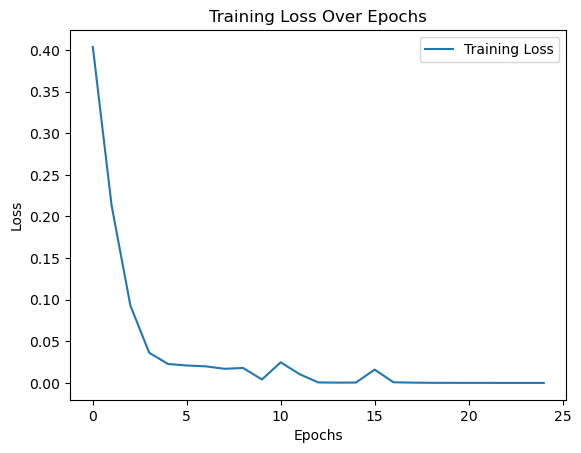

In [16]:
# Plotting the training loss
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

### Evulation 

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Switch to evaluation mode
model.eval()

predictions, true_labels = [], []

# Add tqdm progress bar
for batch in tqdm(test_dataloader, desc="Evaluating"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    predictions.extend(batch_preds)
    true_labels.extend(label_ids)

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")


Evaluating: 100%|██████████| 62/62 [00:05<00:00, 11.67it/s]

Accuracy: 0.9488752556237219


### K-Fold

In [23]:
# Define the KFold cross-validator
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize performance metric list
fold_performance = []

# Parameters
batch_size = 8
epochs = 25
learning_rate = 2e-5

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Start the KFold cross-validation
for fold, (train_ids, test_ids) in enumerate(kf.split(dataset)):
    print(f"FOLD {fold}")
    print("-------------------------------")

    # Split the data into training and validation sets for the current fold
    train_subset = Subset(dataset, train_ids)
    test_subset = Subset(dataset, test_ids)
    
    train_dataloader = DataLoader(train_subset, sampler=RandomSampler(train_subset), batch_size=batch_size)
    test_dataloader = DataLoader(test_subset, sampler=SequentialSampler(test_subset), batch_size=batch_size)
    
    # Initialize the BERT model for sequence classification
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
    model.to(device)
    
    # Define the optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    model.train()
    
    # Training loop for the current fold
    for epoch in range(epochs):
        total_loss = 0
        
        train_progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}/{epochs}, Fold {fold+1}/10")
        
        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            model.zero_grad()
            
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            train_progress_bar.set_postfix(loss=total_loss/(step+1))
        
        train_progress_bar.close()
        
        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)
        
        # Validation step
        model.eval()
        total_eval_accuracy = 0
        total_eval_loss = 0
        
        eval_progress_bar = tqdm(test_dataloader, desc=f"Validation, Fold {fold+1}/10")
        
        for batch in eval_progress_bar:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            
            loss = outputs.loss
            total_eval_loss += loss.item()
            
            # Move logits and labels to CPU
            logits = outputs.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
        
        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
        print(f"Validation accuracy: {avg_val_accuracy}")
        
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(test_dataloader)
        
        # Record all statistics from this epoch.
        fold_performance.append({
            'fold': fold,
            'epoch': epoch,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': avg_val_accuracy
        })

# Calculate and print the average performance across all folds
average_performance = {
    'avg_train_loss': np.mean([x['train_loss'] for x in fold_performance]),
    'avg_val_loss': np.mean([x['val_loss'] for x in fold_performance]),
    'avg_val_accuracy': np.mean([x['val_accuracy'] for x in fold_performance])
}
print(f"Average performance across all folds: {average_performance}")

FOLD 0
-------------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation, Fold 1/10:   0%|          | 0/21 [00:00<?, ?it/s]

Validation accuracy: 0.0


Validation, Fold 1/10:   0%|          | 0/21 [00:47<?, ?it/s]


Validation accuracy: 0.0


Validation, Fold 1/10:   0%|          | 0/21 [00:48<?, ?it/s]


Validation accuracy: 0.0


KeyboardInterrupt: 

### Train #2

In [11]:
# Parameters
batch_size = 16
epochs = 30

# Prepare for epoch_losses
epoch_losses = []

# Create dataloader
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-4)

model.train()

# Training loop
for epoch in range(epochs):
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")

    for batch in progress_bar:
        # b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Update the progress bar
        progress_bar.set_postfix({'loss': total_loss/len(train_dataloader)})
        
    # Calculate and store the average loss for this epoch
    avg_loss = total_loss / len(train_dataloader)
    epoch_losses.append(avg_loss)
    
    # Save the model after each epoch
    # model_save_file = os.path.join(model_save_path, f'bert_model_epoch_{epoch+1}.pt')
    # torch.save(model.state_dict(), model_save_file)

    # Closing the progress bar and printing the epoch loss
    progress_bar.close()
    print(f"Epoch {epoch+1} finished. Loss: {total_loss/len(train_dataloader)}")

# Save
model_save_path = 'models'  
os.makedirs(model_save_path, exist_ok=True)
final_model_save_file = os.path.join(model_save_path, 'bert_final_model_2.pt')
torch.save(model.state_dict(), final_model_save_file)

# print paramter
print("Training Parameters:")
print(f"Batch Size: {batch_size}")
print(f"Epochs: {epochs}")
print(f"Learning Rate: {optimizer.defaults['lr']}")
print(f"Beta1: {optimizer.defaults['betas'][0]}")
print(f"Beta2: {optimizer.defaults['betas'][1]}")
print(f"Training completed. Final model saved to {final_model_save_file}")

# Plotting the training loss
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

c:\Users\Andy Cui\.conda\envs\nlp\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1:   3%|▎         | 2/72 [00:47<27:40, 23.72s/it, loss=0.0166] 


KeyboardInterrupt: 